In [90]:
import pandas as pd
import numpy as ny
from matplotlib import pyplot, gridspec
from plotly import express as exp
from geopy.geocoders import Nominatim

In [53]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data = pd.read_csv('datasets/kc_house_data.csv')

In [21]:
# How to filter rows of a dataframe based on composite conditions?
# data[(data['bedrooms'] == 3) | (data['waterfront'])]

<BarContainer object of 4 artists>

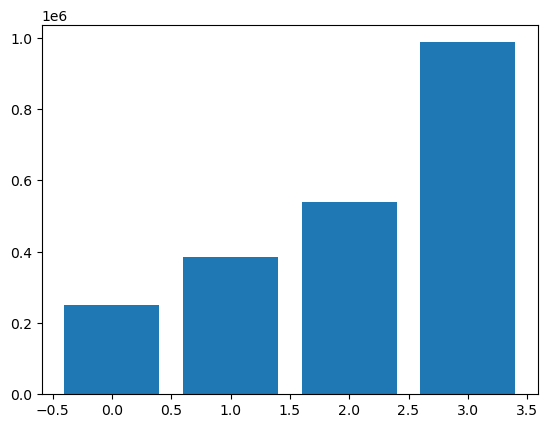

In [54]:
# 1. Qual a média do preço de compra dos imóveis por "Nível"?
#          - Nível 0 -> Preço entre R$0 e R$321.950
#          - Nível 1 -> Preço entre R$321.950 e R$450.000
#          - Nível 2 -> Preço entre R$450.000 e R$645.000
#          - Nível 3 -> Acima de R$645.000

# Using a for loop.
# for i in range(len(data)):
#     if data.loc[i, 'price'] <= 321950:
#         data.loc[i, 'level'] = ny.int64(0)
#     elif data.loc[i, 'price'] <= 450000:
#         data.loc[i, 'level'] = ny.int64(1)
#     elif data.loc[i, 'price'] <= 645000:
#         data.loc[i, 'level'] = ny.int64(2)
#     else:
#         data.loc[i, 'level'] = ny.int64(3)
# # Another way.
# data.loc[data['price'] <= 321950, 'level'] = 0
# data.loc[(data['price'] > 321950) & (data['price'] <= 450000), 'level'] = 1
# data.loc[(data['price'] > 450000) & (data['price'] <= 645000), 'level'] = 2
# data.loc[data['price'] > 645000, 'level'] = 3
# # Yet another better way.
data['level'] = data['price'].apply(lambda price: 0 if price <= 321950 else 1 if price <= 450000 else 2 if price <= 645000 else 3)
# data['level'] = data['level'].astype(ny.int64)
df = data[['price', 'level']].groupby('level').mean().reset_index()
pyplot.bar(df['level'], df['price'])

In [10]:
# 2. Adicionar informacoes de endereco (rua, numero, bairro, cidade e estado) dos imoveis.
def get_if_exists(dict_key, dict_):
    if dict_key in dict_:
        return dict_[dict_key]
    return ''


geo_locator = Nominatim(user_agent='geo_agent')
for i in range(len(data)):
    if i == 10:  # Doing this because of too much data to process.
        break
    lat, long = data.loc[i, 'lat'], data.loc[i, 'long']
    response = geo_locator.reverse(f'{lat},{long}')
    address = response.raw['address']
    # Road or street.
    road = get_if_exists('road', address)
    if not road:
        road = get_if_exists('street', address)
    # Number.
    number = get_if_exists('house_number', address)
    if not number:
        number = get_if_exists('number', address)
    # Neighbourhood or suburb.
    neigh = get_if_exists('neighbourhood', address)
    if not neigh:
        neigh = get_if_exists('suburb', address)
    # City.
    city = get_if_exists('city', address)
    # State.
    state = get_if_exists('state', address)
    # Filling up the data frame.
    data.loc[i, 'road'] = road
    data.loc[i, 'number'] = number
    data.loc[i, 'neighbourhood'] = neigh
    data.loc[i, 'city'] = city
    data.loc[i, 'state'] = state

In [1]:
# Mostre as casas com cores de acordo com seu 'level' e com o tamanho do circulo de acordo com o preco,
map_data = data[['id', 'price', 'level', 'lat', 'long']]
map_chart = exp.scatter_mapbox(
    map_data,
    lat='lat',
    lon='long',
    color='level',
    size='price',
    color_continuous_scale=exp.colors.cyclical.IceFire,
    size_max=15,
    zoom=10
)
map_chart.update_layout(mapbox_style='open-street-map')
map_chart.update_layout(height=600, margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
map_chart.show()


NameError: name 'data' is not defined

In [56]:
# Adding interactive filters.
import ipywidgets as pywid

In [73]:
style = {
    'description_width': 'initial'
}

data['is_waterfront'] = data['waterfront'].apply(lambda x: 'Yes' if x else 'No')
    
# Price filtering slider.
max_price, min_price = data['price'].max(), data['price'].min()
price_slider = pywid.IntSlider(
    value=(max_price + min_price) / 2,
    min=min_price,
    max=max_price,
    step=1,
    description='Price filtering slider $',
    disable=False,
    style=style
)
# Waterfront dropdrown.
waterfront_dropdown = pywid.Dropdown(
    options=data['is_waterfront'].unique().tolist(),
    value='Yes',
    description='Waterfront',
    disable=False
)


def update_map(dataset, waterfront, price_limit):
    map_data = dataset[(dataset['is_waterfront'] == waterfront) & (dataset['price'] <= price_limit)][['id', 'price', 'lat', 'long', 'level']]
    map_chart = exp.scatter_mapbox(
        map_data,
        lat='lat',
        lon='long',
        color='level',
        size='price',
        color_continuous_scale=exp.colors.cyclical.IceFire,
        size_max=15,
        zoom=10
    )
    map_chart.update_layout(mapbox_style='open-street-map')
    map_chart.update_layout(height=600, margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
    map_chart.show() 
    

pywid.interactive(update_map, dataset=pywid.fixed(data), waterfront=waterfront_dropdown, price_limit=price_slider)

interactive(children=(Dropdown(description='Waterfront', index=1, options=('No', 'Yes'), value='Yes'), IntSlid…

In [2]:
# Criando um dashboard com o mapa interativo.
data = pd.read_csv('datasets/kc_house_data.csv')
data['year'] = pd.to_datetime(data['date']).dt.strftime('%Y')
data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m-%d')
data['year_week'] = pd.to_datetime(data['date']).dt.strftime('%Y-%U')

# Widgets.
date_slider = pywid.SelectionSlider(
    options = data['date'].sort_values().unique().tolist(),
    value=data['date'].min(),
    description='Available',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)


def update_map(data, date_limit):
    filtered_data = data[data['date'] >= date_limit]
    fig = pyplot.figure(figsize=(20, 12))
    specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    ax1 = fig.add_subplot(specs[0, :])
    ax2 = fig.add_subplot(specs[1, 0])
    ax3 = fig.add_subplot(specs[1, 1])
    
    data_ax1 = filtered_data[['price', 'year']].groupby('year').mean().reset_index()
    ax1.set_title('Average Price by Year')
    ax1.bar(data_ax1['year'], data_ax1['price'])
    
    data_ax2 = filtered_data[['price', 'date']].groupby('date').mean().reset_index()
    ax2.set_title('Average Price by Date')
    pyplot.xticks(rotation=90)
    ax2.plot(data_ax2['date'], data_ax2['price'])
    
    data_ax3 = filtered_data[['price', 'year_week']].groupby('year_week').mean().reset_index()
    ax3.set_title('Average Price by Year Week')
    pyplot.xticks(rotation=90)
    ax3.plot(data_ax3['year_week'], data_ax3['price'])
    
    
pywid.interactive(update_map, data=pywid.fixed(data), date_limit=date_slider)

NameError: name 'pd' is not defined